In [8]:
import glob
import pandas as pd
import subprocess
import gseapy as gp
import matplotlib.pyplot as plt
from gseapy import barplot, dotplot
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [9]:
github_dir = '/home/qzeng_salk_edu/project/241207_zhwu_ml/aging-gene-prediction/ml_output/'
ct = 'Oligo_NN'
ml_out = pd.read_csv(f"{github_dir}/{ct}/result.csv")

In [4]:
# get the right predictions
right_pred = ml_out[ml_out['pred'] == ml_out['DEG']].sort_values('DEG')
right_pred = right_pred[right_pred['DEG'] != 0]
right_pred = right_pred.set_index('gene')[['dmr', 'mcg_genebody', 'mch_genebody', 'atac','hic_loop', 'hic_abc_dmr', 'hic_abc_peak']]
right_pred


,dmr,mcg_genebody,mch_genebody,atac,hic_loop,hic_abc_dmr,hic_abc_peak
gene,,,,,,,
Aplp1,0.167493,0.119190,0.091327,0.242515,0.101377,0.139001,0.139096
Diablo,0.110808,0.186349,0.126285,0.132466,0.150985,0.133129,0.159979
Ndufa13,0.096932,0.179376,0.110471,0.081195,0.144830,0.188746,0.198449
Yif1b,0.103887,0.141396,0.118397,0.097272,0.155583,0.205968,0.177498
Txndc17,0.095911,0.210040,0.109306,0.061648,0.122142,0.141683,0.259270
...,...,...,...,...,...,...,...
Scarb1,0.088765,0.116365,0.191517,0.301173,0.140711,0.089575,0.071894
Cobll1,0.234264,0.090008,0.080082,0.191756,0.192312,0.156898,0.054679
Cadps2,0.158595,0.094993,0.086468,0.279971,0.057380,0.223084,0.099509


In [5]:
# add a columns as category, whichi columns is the max value
right_pred['category'] = right_pred.idxmax(axis=1)
right_pred

,dmr,mcg_genebody,mch_genebody,atac,hic_loop,hic_abc_dmr,hic_abc_peak,category
gene,,,,,,,,
Aplp1,0.167493,0.119190,0.091327,0.242515,0.101377,0.139001,0.139096,atac
Diablo,0.110808,0.186349,0.126285,0.132466,0.150985,0.133129,0.159979,mcg_genebody
Ndufa13,0.096932,0.179376,0.110471,0.081195,0.144830,0.188746,0.198449,hic_abc_peak
Yif1b,0.103887,0.141396,0.118397,0.097272,0.155583,0.205968,0.177498,hic_abc_dmr
Txndc17,0.095911,0.210040,0.109306,0.061648,0.122142,0.141683,0.259270,hic_abc_peak
...,...,...,...,...,...,...,...,...
Scarb1,0.088765,0.116365,0.191517,0.301173,0.140711,0.089575,0.071894,atac
Cobll1,0.234264,0.090008,0.080082,0.191756,0.192312,0.156898,0.054679,dmr
Cadps2,0.158595,0.094993,0.086468,0.279971,0.057380,0.223084,0.099509,atac


In [35]:
all_df = []

for category, tmpdf in right_pred.groupby('category'):
    gene_list = tmpdf.index.tolist()
    go_enrichment = gp.enrichr(gene_list= gene_list,
                        gene_sets=['GO_Biological_Process_2023'],#'GO_Molecular_Function_2018','KEGG_2016','WikiPathways_2019_Mouse','KEGG_2019_Mouse'
                        organism='Mouse', # don't forget to set organism
                        #outdir='test/go', # set the output directory
                        no_plot=False, # do not draw a plot
                        cutoff=0.05) # set a significance cutoff
    #filter for GO result
    result_df= go_enrichment.results.copy()

    result_df = result_df[result_df['P-value']  < 1e-5]
    result_df['num_genes'] = result_df['Overlap'].apply(lambda x: int(x.split('/')[0]))
    result_df = result_df[result_df['num_genes'] >= 5]

    result_df['-log10(p)'] = -np.log10(result_df['P-value'] + 1e-30)
    result_df =result_df.set_index('Term')[['-log10(p)']]
    result_df.index = [_go.split('(')[0] for _go in result_df.index]
    result_df.columns = [category]
    all_df.append(result_df)

all_df = pd.concat(all_df, axis=1)


In [36]:
# drop columns with all nana
all_df = all_df.dropna(axis=1, how='all')
# fillna with 0
all_df = all_df.fillna(0) 
all_df

,atac,hic_abc_dmr,hic_abc_peak,mcg_genebody
Nervous System Development,5.120558,0.000000,0.000000,0.000000
Cellular Respiration,0.000000,9.775865,26.825942,6.644219
Aerobic Electron Transport Chain,0.000000,9.664666,25.390240,5.697176
Mitochondrial ATP Synthesis Coupled Electron Transport,0.000000,9.523429,25.017759,5.634348
Cytoplasmic Translation,0.000000,7.076444,30.000000,16.149915
Substantia Nigra Development,0.000000,6.436240,0.000000,0.000000
Macromolecule Biosynthetic Process,0.000000,5.999783,30.000000,12.549356
"Mitochondrial Electron Transport, NADH To Ubiquinone",0.000000,5.741563,10.759281,0.000000
Aerobic Respiration,0.000000,5.403758,15.364878,6.006576
Mitochondrial Respiratory Chain Complex Assembly,0.000000,5.142202,9.903328,0.000000


Text(0.5, 1.0, 'Oligo_NN')

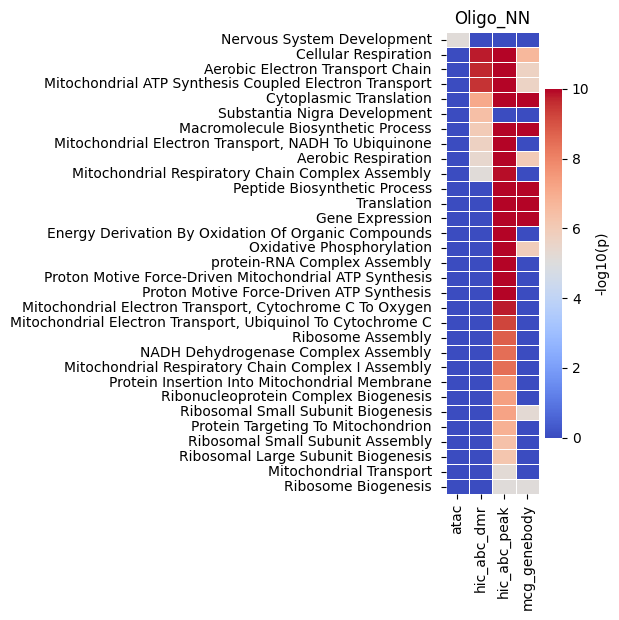

In [37]:
fig, ax = plt.subplots(figsize=(1.5, 6), dpi = 100)
sns.heatmap(all_df, cmap='coolwarm', linewidths=0.5, ax = ax, vmin = 0, vmax = 10) 
#label the colorbar as -log10(p)
cbar = ax.collections[0].colorbar
cbar.set_label('-log10(p)')
ax.set_title(ct)